In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler


from numba import njit, jit, jitclass  

from math import sqrt
from scipy.linalg.special_matrices import toeplitz
from scipy.linalg import svdvals
from scipy.linalg import norm
from scipy.optimize import check_grad
from scipy.optimize import fmin_l_bfgs_b

from sklearn.metrics import mean_squared_error

## Import of data

In [2]:
df = pd.read_csv('C:/Users/aviga/Downloads/insertion.csv',sep=';')
df.head()

,annee,diplome,numero_de_l_etablissement,etablissement,etablissementactuel,code_de_l_academie,academie,code_du_domaine,domaine,code_de_la_discipline,...,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile,cle_etab,cle_disc,id_paysage
0,2016,MASTER LMD,0141408E,Caen Normandie,NaN,A05,Caen,STS,"Sciences, technologies et santé",disc15,...,8.6,1810,ns,ns,ns,1460,2100,Caen Normandie_18,disc15_18,p25Q3
1,2016,MASTER LMD,0141408E,Caen Normandie,NaN,A05,Caen,STS,"Sciences, technologies et santé",disc16,...,8.6,1810,ns,ns,29,1460,2100,Caen Normandie_18,disc16_18,p25Q3
2,2016,MASTER LMD,0141408E,Caen Normandie,NaN,A05,Caen,STS,"Sciences, technologies et santé",disc16,...,8.6,1810,ns,ns,29,1460,2100,Caen Normandie_30,disc16_30,p25Q3
3,2016,MASTER LMD,0141408E,Caen Normandie,NaN,A05,Caen,STS,"Sciences, technologies et santé",disc17,...,8.6,1810,ns,ns,ns,1460,2100,Caen Normandie_18,disc17_18,p25Q3
4,2016,MASTER LMD,0171463Y,La Rochelle,NaN,A13,Poitiers,DEG,"Droit, économie et gestion",disc02,...,8.1,1725,ns,ns,ns,1380,2025,La Rochelle_18,disc02_18,atbEK


In [3]:
df.columns

Index(['annee', 'diplome', 'numero_de_l_etablissement', 'etablissement',
       'etablissementactuel', 'code_de_l_academie', 'academie',
       'code_du_domaine', 'domaine', 'code_de_la_discipline', 'discipline',
       'situation', 'remarque', 'nombre_de_reponses', 'taux_de_reponse',
       'poids_de_la_discipline', 'taux_dinsertion',
       'emplois_cadre_ou_professions_intermediaires', 'emplois_stables',
       'emplois_a_temps_plein', 'salaire_net_median_des_emplois_a_temps_plein',
       'salaire_brut_annuel_estime', 'de_diplomes_boursiers',
       'taux_de_chomage_regional', 'salaire_net_mensuel_median_regional',
       'emplois_cadre', 'emplois_exterieurs_a_la_region_de_luniversite',
       'femmes', 'salaire_net_mensuel_regional_1er_quartile',
       'salaire_net_mensuel_regional_3eme_quartile', 'cle_etab', 'cle_disc',
       'id_paysage'],
      dtype='object')

In [4]:
df['remarque']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
13792    NaN
13793    NaN
13794    NaN
13795    NaN
13796    NaN
Name: remarque, Length: 13797, dtype: object

We can notice that some variables are redundant (numero_de_l_etablissement/etablissement, code_de_l_academie/academie, code_du_domaine/domaine...) or not informative. 
In order to simplify the data, I decided to keep only some features. These variables make sense for the task I chose (predict the salary).

In [5]:
df=df[['annee','diplome','etablissement','code_de_la_discipline','situation','emplois_cadre_ou_professions_intermediaires','taux_de_chomage_regional','femmes','salaire_net_median_des_emplois_a_temps_plein']]

In [6]:
df.describe(include=['object', 'bool'])

,diplome,etablissement,code_de_la_discipline,situation,emplois_cadre_ou_professions_intermediaires,taux_de_chomage_regional,femmes,salaire_net_median_des_emplois_a_temps_plein
count,13797,13797,13797,13797,13559,13797,13591,13559
unique,2,90,20,2,71,59,100,145
top,MASTER LMD,Dijon - Bourgogne,disc07,30 mois après le diplôme,ns,9,ns,ns
freq,12886,253,964,7911,6440,957,5362,7359


The documentation associated to the data specifies that some information are not available ('nd') or non significant ('ns'). We will then remove the rows with missing values. 

In [7]:
df = df[df['emplois_cadre_ou_professions_intermediaires'] != 'ns']
df = df[df['femmes'] != 'ns']
df = df[df['femmes'] != 'nd']
df = df[df['salaire_net_median_des_emplois_a_temps_plein'] != 'ns']
df = df[df['salaire_net_median_des_emplois_a_temps_plein'] != 'nd']
df = df[df['taux_de_chomage_regional'] != 'nd']
df = df[df['taux_de_chomage_regional'] != 'fe']

df.dropna(inplace=True)

In [8]:
df.dtypes

annee                                            int64
diplome                                         object
etablissement                                   object
code_de_la_discipline                           object
situation                                       object
emplois_cadre_ou_professions_intermediaires     object
taux_de_chomage_regional                        object
femmes                                          object
salaire_net_median_des_emplois_a_temps_plein    object
dtype: object

Some variables can be considered as numerical and others are categorical. 

In [9]:
# numerical variables 

df['emplois_cadre_ou_professions_intermediaires']=df['emplois_cadre_ou_professions_intermediaires'].astype(int)
df['taux_de_chomage_regional']=df['taux_de_chomage_regional'].astype(float)
df['femmes']=df['femmes'].astype(int)
df['salaire_net_median_des_emplois_a_temps_plein']=df['salaire_net_median_des_emplois_a_temps_plein'].astype(int)

In [10]:
df.head()

,annee,diplome,etablissement,code_de_la_discipline,situation,emplois_cadre_ou_professions_intermediaires,taux_de_chomage_regional,femmes,salaire_net_median_des_emplois_a_temps_plein
5,2016,MASTER LMD,La Rochelle,disc04,30 mois après le diplôme,95,8.1,59,1920
12,2016,MASTER LMD,Dijon - Bourgogne,disc07,18 mois après le diplôme,81,7.5,79,1540
13,2016,MASTER LMD,Dijon - Bourgogne,disc12,18 mois après le diplôme,90,7.5,42,1750
14,2016,MASTER LMD,Dijon - Bourgogne,disc12,30 mois après le diplôme,90,7.5,42,1860
19,2016,MASTER ENS,Besançon - Franche-Comté,disc18,18 mois après le diplôme,94,7.5,76,1750


## Data Visualization

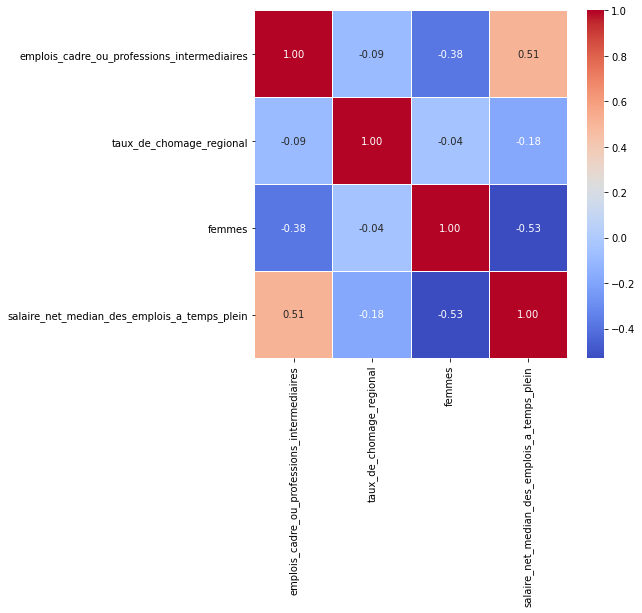

In [11]:
#heatmap to see correlations between numerical features

f, ax = plt.subplots(figsize=(7, 6))
corr = df.iloc[:,5:9].corr()
hm = sb.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)

We notice that : 
-  'emplois_cadre_ou_professions_intermediaires' and 'salaire_net_median_des_emplois_a_temps_plein' are positively correlated. It makes sense, because the salary increases with the status.
- 'femmes' and 'salaire_net_median_des_emplois_a_temps_plein' are negatively correlated, meaning that more we have women, less the salary is important. A good representation of this sad reality...  

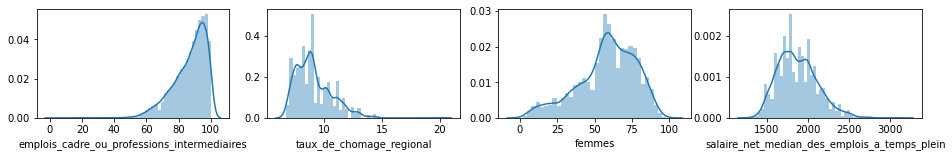

In [12]:
#histograms for numerical features

features = df.iloc[:,5:9]
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=2.0)
j=1
for feat in features:
    plt.subplot(4,5,j)
    sb.distplot(df[feat])
    j+=1

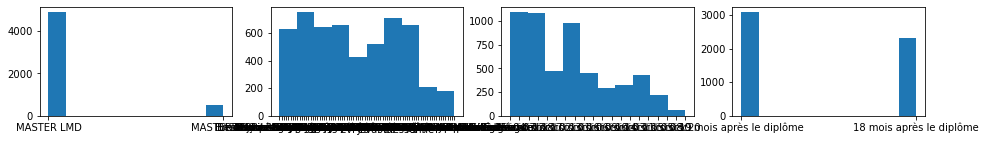

In [13]:
#histograms for categorical features

cat_features = df.iloc[:,1:5]

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=2.0)
j=1
for feat in cat_features:
    plt.subplot(4,5,j)
    x = df[feat]
    plt.hist(x,label=feat)
    j+=1

## Preparation of data

For categorical variables, we encode them using LabelEncoder from sklearn.

In [14]:
# categorical variables 

label = LabelEncoder()
df['annee']=label.fit_transform(df['annee'])  #??
df['diplome']=label.fit_transform(df['diplome'])
df['etablissement']=label.fit_transform(df['etablissement'])
df['code_de_la_discipline']=label.fit_transform(df['code_de_la_discipline'])
df['situation']=label.fit_transform(df['situation'])

In [15]:
scaler = RobustScaler()
df = scaler.fit_transform(df)

X = df[:,0:8]
y = df[:,-1]

In [16]:
X=np.array(X)
y=np.array(y)

X=X[0:5000,:]
y=y[0:5000]

n=X.shape[0]
d=X.shape[1]

In [17]:
n,d

(5000, 8)

## Implementation

Our data is ready. The objective is now to use the different methods of the course in order to minimize the objective function (linear regression):$$
    \min_{w \in \mathbb{R}^d} f(w) := \frac{1}{2 n} \|X w - y\|^2  
$$

I will use the code from 'OptimizationForML-LabSG'.

In [18]:
# Python class for linear regression problems
class LinReg(object):
   
    # Instantiate the class
    def __init__(self, X, y,lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        
    
    # Objective value
    def fun(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) 
    
    # Partial objective value
    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) 
    
    # Full gradient computation
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n 
    
    # Partial gradient computation
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i 
    
    # Partial gradient (alternate calculation using xi^T*w) - USED IN PART III ONLY
    def grad_xi(self,i,xiw):
        x_i = self.X[i]
        return (xiw - self.y[i]) * x_i

    # Lipschitz constant for the gradient
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n 
        return L
    
    # ''Strong'' convexity constant (can be zero in theory here)
    def cvxval(self):
        s = svdvals(self.X)
        mu = min(s)**2 / self.n 
        return mu   

In [19]:
pblinreg = LinReg(X, y, 0)

In [20]:
# Check for the linear regression problem
print(check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d)))
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    grad_error.append((pblinreg.f_i( ind[0], w+eps*vec) - pblinreg.f_i( ind[0], w))/eps - np.dot(pblinreg.grad_i(ind[0],w),vec)) 
print(np.mean(grad_error))

6.847701925127056e-07
1.689388858006926e-07


In [21]:
# Use L-BFGS-B to determine a solution for linear regression

w_init = np.zeros(d)

w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(w_min_lin)))

0.14053063243717023
9.909658054403196e-10


In [22]:
def stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            average: Indicates whether the method computes the average of the iterates 
                0: No averaging (default)
                1: With averaging
            scaling: Use a diagonal scaling
                0: No scaling (default)
                1: Average of magnitudes (RMSProp)
                2: Normalization with magnitudes (Adagrad)
            
        Outputs:
            w_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)
    
    # Average (if needed)
    if average:
            wavg=np.zeros(len(w))
    
    #Scaling values
    if scaling>0:
        nu=1/(2 *(n ** (0.5)))
        R = np.zeros(d)
        tau = 0.8

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    print("Stochastic Gradient, batch size=",nb,"/",n)
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=False)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        
        if scaling>0:
            if scaling==1:
                #tau = 0.
                R = tau*R + (1-tau)*sg*sg
            elif scaling==2:
                R = R + sg*sg 
            sg = sg/(np.sqrt(R+nu))
            
        if stepchoice==0:
            w[:] = w - (1/L) * sg
        elif stepchoice==1:
            sk = float(step0/(sqrt(k+1)))
            w[:] = w - sk * sg
        
        nw = norm(w) #Computing the norm to measure divergence 
        
        if average:
            # If average, compute the average of the iterates
            wavg = k/(k+1) *wavg + w/(k+1) 
            nmin = norm(wavg-wtarget)
            obj = problem.fun(wavg)
        else:
            obj = problem.fun(w)
            nmin = norm(w-wtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    if average:
        w_output = wavg.copy()
    else:
        w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(normits)

## (Batch) gradient descent 

### Constant stepsize

In [23]:
nb_epochs = 100
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

# Gradient descent with constant stepsize
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

Stochastic Gradient, batch size= 5000 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
       1 | 1.68e-01 | 8.83e-01
       2 | 1.58e-01 | 8.21e-01
       3 | 1.54e-01 | 7.75e-01
       4 | 1.52e-01 | 7.37e-01
       5 | 1.51e-01 | 7.01e-01
       6 | 1.50e-01 | 6.68e-01
       7 | 1.49e-01 | 6.37e-01
       8 | 1.48e-01 | 6.07e-01
       9 | 1.48e-01 | 5.79e-01
      10 | 1.47e-01 | 5.52e-01
      11 | 1.46e-01 | 5.26e-01
      12 | 1.46e-01 | 5.02e-01
      13 | 1.45e-01 | 4.79e-01
      14 | 1.45e-01 | 4.56e-01
      15 | 1.45e-01 | 4.35e-01
      16 | 1.44e-01 | 4.15e-01
      17 | 1.44e-01 | 3.96e-01
      18 | 1.44e-01 | 3.78e-01
      19 | 1.43e-01 | 3.60e-01
      20 | 1.43e-01 | 3.43e-01
      21 | 1.43e-01 | 3.28e-01
      22 | 1.43e-01 | 3.12e-01
      23 | 1.42e-01 | 2.98e-01
      24 | 1.42e-01 | 2.84e-01
      25 | 1.42e-01 | 2.71e-01
      26 | 1.42e-01 | 2.58e-01
      27 | 1.42e-01 | 2.46e-01
      28 | 1.42e-01 | 2.35e-01
      29 | 1.42e-01 | 2.2

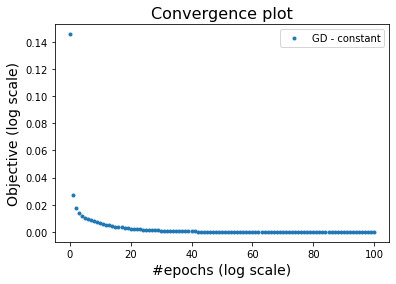

In [24]:
plt.plot(obj_a-f_min_lin,'.', label="GD - constant", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

### Descent stepsize

In [25]:
# Gradient descent with descent stepsize
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs,nb=n)

Stochastic Gradient, batch size= 5000 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
       1 | 2.50e-01 | 1.04e+00
       2 | 2.32e-01 | 1.01e+00
       3 | 2.20e-01 | 9.88e-01
       4 | 2.11e-01 | 9.72e-01
       5 | 2.05e-01 | 9.60e-01
       6 | 2.00e-01 | 9.49e-01
       7 | 1.95e-01 | 9.40e-01
       8 | 1.92e-01 | 9.31e-01
       9 | 1.89e-01 | 9.24e-01
      10 | 1.86e-01 | 9.18e-01
      11 | 1.84e-01 | 9.12e-01
      12 | 1.82e-01 | 9.06e-01
      13 | 1.80e-01 | 9.01e-01
      14 | 1.78e-01 | 8.97e-01
      15 | 1.77e-01 | 8.92e-01
      16 | 1.76e-01 | 8.88e-01
      17 | 1.74e-01 | 8.84e-01
      18 | 1.73e-01 | 8.81e-01
      19 | 1.72e-01 | 8.77e-01
      20 | 1.71e-01 | 8.74e-01
      21 | 1.71e-01 | 8.71e-01
      22 | 1.70e-01 | 8.68e-01
      23 | 1.69e-01 | 8.65e-01
      24 | 1.69e-01 | 8.63e-01
      25 | 1.68e-01 | 8.60e-01
      26 | 1.67e-01 | 8.58e-01
      27 | 1.67e-01 | 8.55e-01
      28 | 1.66e-01 | 8.53e-01
      29 | 1.66e-01 | 8.5

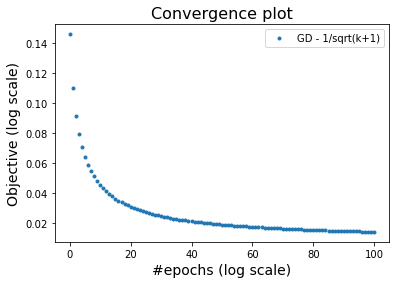

In [26]:
plt.plot(obj_b-f_min_lin,'.', label="GD - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

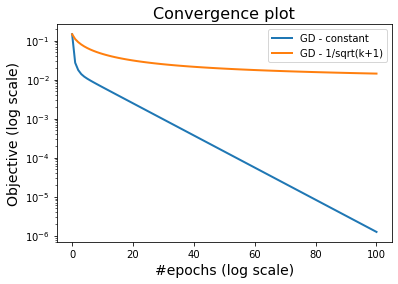

In [27]:
#Constant vs decreasing stepsize

plt.semilogy(obj_a-f_min_lin, label="GD - constant", lw=2)
plt.semilogy(obj_b-f_min_lin, label="GD - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

### Accelerated gradient descent (Nesterov)

I will use my own code for this part.

In [46]:
def nesterov(x0,y0,problem,wtarget,n_iter): 
   
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)
    

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    print('Nesterov')
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    alpha=1/L
    u=[x0]
    v=[y0]
    lbda=[0]
    gamma_=[]
    while (k < n_iter and nw < 10**100):
        sg = problem.grad(w)
        u.append(v[-1]-alpha*problem.grad(v[-1]))
        
        lbda.append(1 + np.sqrt(1 + 4 * lbda[-1] * lbda[-1]) / 2)
        lbda_suiv = 1 + np.sqrt(1 + 4 * lbda[-1] * lbda[-1]) / 2
        gamma_.append((lbda[-1]-1)/lbda_suiv)
         
        v.append(u[-1]+gamma_[-1]*(u[-1]-u[-2]))
        
        
        nw = norm(u[-1]) #Computing the norm to measure divergence 
        obj = problem.fun(u[-1])
        nmin = norm(u[-1]-wtarget)
        
        k += 1
        
        objvals.append(obj)
        normits.append(nmin)
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################             
    
    w_output = u[-1].copy()
    
    return w_output, np.array(objvals), np.array(normits)

In [47]:
x0 = np.zeros(d)
y0 = x0

# Nesterov 
w_n, obj_n, nits_n = nesterov(x0,y0,pblinreg,w_min_lin,n_iter=100)

Nesterov
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
       1 | 1.68e-01 | 8.83e-01
       2 | 1.57e-01 | 8.10e-01
       3 | 1.53e-01 | 7.45e-01
       4 | 1.50e-01 | 6.78e-01
       5 | 1.48e-01 | 6.07e-01
       6 | 1.46e-01 | 5.31e-01
       7 | 1.45e-01 | 4.53e-01
       8 | 1.44e-01 | 3.75e-01
       9 | 1.42e-01 | 2.99e-01
      10 | 1.42e-01 | 2.26e-01
      11 | 1.41e-01 | 1.57e-01
      12 | 1.41e-01 | 9.51e-02
      13 | 1.41e-01 | 4.00e-02
      14 | 1.41e-01 | 7.67e-03
      15 | 1.41e-01 | 4.64e-02
      16 | 1.41e-01 | 7.69e-02
      17 | 1.41e-01 | 9.93e-02
      18 | 1.41e-01 | 1.14e-01
      19 | 1.41e-01 | 1.21e-01
      20 | 1.41e-01 | 1.21e-01
      21 | 1.41e-01 | 1.16e-01
      22 | 1.41e-01 | 1.06e-01
      23 | 1.41e-01 | 9.28e-02
      24 | 1.41e-01 | 7.66e-02
      25 | 1.41e-01 | 5.88e-02
      26 | 1.41e-01 | 4.04e-02
      27 | 1.41e-01 | 2.23e-02
      28 | 1.41e-01 | 5.10e-03
      29 | 1.41e-01 | 1.04e-02
      30 | 1.41e-01 | 2.38e-02

Text(0, 0.5, 'Objective (log scale)')

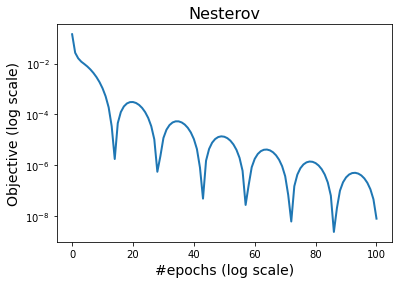

In [48]:
plt.semilogy(obj_n-f_min_lin, lw=2)
plt.title("Nesterov", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)

## Stochastic gradient descent 

### Impact of stepsize/learning rate


In [34]:
# Stochastic gradient with constant stepsize ; the version below diverges - The bound on norm(w) in the code will be triggered
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=nb_epochs*n,nb=1)

Stochastic Gradient, batch size= 1 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
     830 | 2.94e+199 | 1.20e+100


We can see that in our case, SGD with constant stepsize does not converge. We then use a decreasing stepsize. 

In [35]:
# Stochastic gradient with decreasing stepsize
w_d, obj_d, nits_d = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)

Stochastic Gradient, batch size= 1 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
    5000 | 1.42e-01 | 2.32e-01
   10000 | 1.41e-01 | 1.17e-01
   15000 | 1.41e-01 | 8.59e-02
   20000 | 1.41e-01 | 6.73e-02
   25000 | 1.41e-01 | 4.99e-02
   30000 | 1.41e-01 | 3.55e-02
   35000 | 1.41e-01 | 2.85e-02
   40000 | 1.41e-01 | 2.97e-02
   45000 | 1.41e-01 | 2.91e-02
   50000 | 1.41e-01 | 2.54e-02
   55000 | 1.41e-01 | 2.00e-02
   60000 | 1.41e-01 | 3.83e-02
   65000 | 1.41e-01 | 3.94e-02
   70000 | 1.41e-01 | 1.75e-02
   75000 | 1.41e-01 | 2.20e-02
   80000 | 1.41e-01 | 1.73e-02
   85000 | 1.41e-01 | 2.71e-02
   90000 | 1.41e-01 | 1.17e-02
   95000 | 1.41e-01 | 3.24e-02
  100000 | 1.41e-01 | 3.20e-02
  105000 | 1.41e-01 | 2.53e-02
  110000 | 1.41e-01 | 2.88e-02
  115000 | 1.41e-01 | 4.64e-02
  120000 | 1.41e-01 | 2.89e-02
  125000 | 1.41e-01 | 1.84e-02
  130000 | 1.41e-01 | 2.08e-02
  135000 | 1.41e-01 | 3.59e-02
  140000 | 1.41e-01 | 4.18e-02
  145000 | 1.41e-01 | 1.96e-

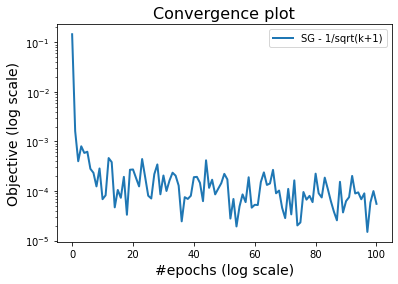

In [36]:
plt.semilogy(obj_d-f_min_lin, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

### (Mini-) Batch size

In [37]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

# Stochastic gradient (batch size 1)
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Batch stochastic gradient (batch size n/100)
nbset=int(n/100)
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)
# Batch stochastic gradient (batch size n/10)
nbset=int(n/10)
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)
# Batch stochastic gradient (batch size n/2)
nbset=int(n/2)
w_d, obj_d, nits_d = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)
# Gradient descent (batch size n)
w_e, obj_e, nits_e = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs),nb=n)

Stochastic Gradient, batch size= 1 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
    5000 | 1.43e-01 | 3.04e-01
   10000 | 1.42e-01 | 1.98e-01
   15000 | 1.42e-01 | 1.53e-01
   20000 | 1.41e-01 | 1.17e-01
   25000 | 1.41e-01 | 8.61e-02
   30000 | 1.41e-01 | 9.15e-02
   35000 | 1.41e-01 | 8.39e-02
   40000 | 1.41e-01 | 7.29e-02
   45000 | 1.41e-01 | 6.78e-02
   50000 | 1.41e-01 | 5.22e-02
   55000 | 1.41e-01 | 6.73e-02
   60000 | 1.41e-01 | 4.27e-02
   65000 | 1.41e-01 | 4.22e-02
   70000 | 1.41e-01 | 4.07e-02
   75000 | 1.41e-01 | 3.40e-02
   80000 | 1.41e-01 | 4.60e-02
   85000 | 1.41e-01 | 2.41e-02
   90000 | 1.41e-01 | 2.42e-02
   95000 | 1.41e-01 | 3.33e-02
  100000 | 1.41e-01 | 3.54e-02
  105000 | 1.41e-01 | 3.08e-02
  110000 | 1.41e-01 | 2.41e-02
  115000 | 1.41e-01 | 2.90e-02
  120000 | 1.41e-01 | 2.61e-02
  125000 | 1.41e-01 | 2.08e-02
  130000 | 1.41e-01 | 2.36e-02
  135000 | 1.41e-01 | 2.88e-02
  140000 | 1.41e-01 | 2.91e-02
  145000 | 1.41e-01 | 3.83e-

     560 | 1.48e-01 | 6.02e-01
     570 | 1.48e-01 | 6.00e-01
     580 | 1.48e-01 | 5.98e-01
     590 | 1.48e-01 | 5.96e-01
     600 | 1.48e-01 | 5.94e-01
     610 | 1.48e-01 | 5.92e-01
     620 | 1.48e-01 | 5.90e-01
     630 | 1.48e-01 | 5.88e-01
     640 | 1.48e-01 | 5.86e-01
     650 | 1.48e-01 | 5.84e-01
     660 | 1.48e-01 | 5.83e-01
     670 | 1.48e-01 | 5.81e-01
     680 | 1.48e-01 | 5.79e-01
     690 | 1.48e-01 | 5.77e-01
     700 | 1.48e-01 | 5.75e-01
     710 | 1.47e-01 | 5.73e-01
     720 | 1.47e-01 | 5.72e-01
     730 | 1.47e-01 | 5.70e-01
     740 | 1.47e-01 | 5.68e-01
     750 | 1.47e-01 | 5.66e-01
     760 | 1.47e-01 | 5.64e-01
     770 | 1.47e-01 | 5.63e-01
     780 | 1.47e-01 | 5.61e-01
     790 | 1.47e-01 | 5.59e-01
     800 | 1.47e-01 | 5.58e-01
     810 | 1.47e-01 | 5.56e-01
     820 | 1.47e-01 | 5.54e-01
     830 | 1.47e-01 | 5.53e-01
     840 | 1.47e-01 | 5.51e-01
     850 | 1.47e-01 | 5.50e-01
     860 | 1.47e-01 | 5.48e-01
     870 | 1.47e-01 | 5.47e-01
     880

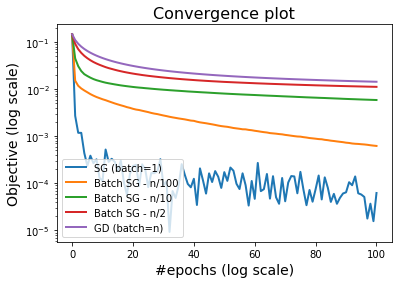

In [38]:
# Plot the comparison of variants of batch SGD with the same stepsize rule

# In terms of objective value (logarithmic scale)
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_e-f_min_lin, label="GD (batch=n)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

### Diagonal scaling

In [39]:
# Comparison of stochastic gradient with and without diagonal scaling

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

# Stochastic gradient (batch size 1) without diagonal scaling
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=1)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Constant step size
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=2)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Decreasing step size
w_d, obj_d, nits_d = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=2)

Stochastic Gradient, batch size= 1 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
    5000 | 1.43e-01 | 2.91e-01
   10000 | 1.42e-01 | 1.84e-01
   15000 | 1.41e-01 | 1.42e-01
   20000 | 1.41e-01 | 1.16e-01
   25000 | 1.41e-01 | 8.89e-02
   30000 | 1.41e-01 | 7.20e-02
   35000 | 1.41e-01 | 7.07e-02
   40000 | 1.41e-01 | 6.48e-02
   45000 | 1.41e-01 | 5.51e-02
   50000 | 1.41e-01 | 4.94e-02
   55000 | 1.41e-01 | 5.11e-02
   60000 | 1.41e-01 | 2.91e-02
   65000 | 1.41e-01 | 3.43e-02
   70000 | 1.41e-01 | 3.87e-02
   75000 | 1.41e-01 | 3.53e-02
   80000 | 1.41e-01 | 2.62e-02
   85000 | 1.41e-01 | 1.19e-02
   90000 | 1.41e-01 | 2.52e-02
   95000 | 1.41e-01 | 1.69e-02
  100000 | 1.41e-01 | 2.12e-02
  105000 | 1.41e-01 | 3.22e-02
  110000 | 1.41e-01 | 2.32e-02
  115000 | 1.41e-01 | 2.54e-02
  120000 | 1.41e-01 | 2.27e-02
  125000 | 1.41e-01 | 1.38e-02
  130000 | 1.41e-01 | 2.28e-02
  135000 | 1.41e-01 | 2.49e-02
  140000 | 1.41e-01 | 2.95e-02
  145000 | 1.41e-01 | 3.72e-

  280000 | 1.41e-01 | 6.20e-02
  285000 | 1.41e-01 | 5.72e-02
  290000 | 1.42e-01 | 9.62e-02
  295000 | 1.42e-01 | 6.42e-02
  300000 | 1.42e-01 | 9.88e-02
  305000 | 1.42e-01 | 6.70e-02
  310000 | 1.41e-01 | 7.41e-02
  315000 | 1.41e-01 | 6.62e-02
  320000 | 1.41e-01 | 6.56e-02
  325000 | 1.41e-01 | 1.02e-01
  330000 | 1.42e-01 | 8.24e-02
  335000 | 1.42e-01 | 8.80e-02
  340000 | 1.42e-01 | 7.07e-02
  345000 | 1.41e-01 | 6.68e-02
  350000 | 1.41e-01 | 4.22e-02
  355000 | 1.41e-01 | 6.95e-02
  360000 | 1.41e-01 | 6.97e-02
  365000 | 1.41e-01 | 8.68e-02
  370000 | 1.42e-01 | 7.11e-02
  375000 | 1.42e-01 | 1.16e-01
  380000 | 1.41e-01 | 6.62e-02
  385000 | 1.42e-01 | 8.93e-02
  390000 | 1.42e-01 | 1.02e-01
  395000 | 1.42e-01 | 9.13e-02
  400000 | 1.41e-01 | 8.37e-02
  405000 | 1.41e-01 | 1.00e-01
  410000 | 1.41e-01 | 6.49e-02
  415000 | 1.43e-01 | 1.42e-01
  420000 | 1.41e-01 | 4.40e-02
  425000 | 1.41e-01 | 7.28e-02
  430000 | 1.42e-01 | 8.99e-02
  435000 | 1.41e-01 | 1.05e-01
  440000

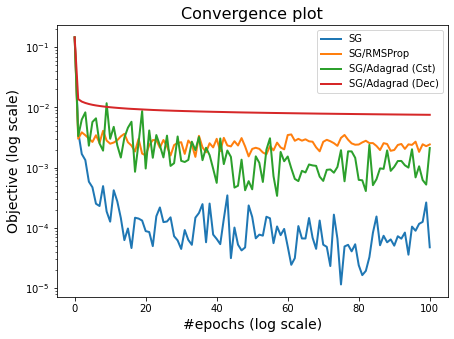

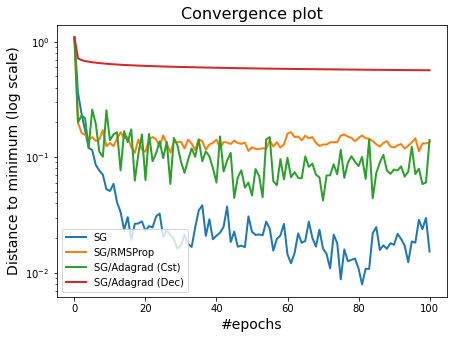

In [43]:
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SG/RMSProp", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(obj_d-f_min_lin, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of distance to the minimum (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_b, label="SG/RMSProp", lw=2)
plt.semilogy(nits_c, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(nits_d, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()

### Stochastic gradient with averaging (Iterate averaging)

In [44]:
# Comparison of stochastic gradient with and without averaging

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

# Stochastic gradient (batch size 1) without averaging
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Stochastic gradient (batch size 1) with averaging
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=1)

Stochastic Gradient, batch size= 1 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
    5000 | 1.43e-01 | 2.70e-01
   10000 | 1.42e-01 | 1.66e-01
   15000 | 1.41e-01 | 1.12e-01
   20000 | 1.41e-01 | 7.57e-02
   25000 | 1.41e-01 | 7.96e-02
   30000 | 1.41e-01 | 5.36e-02
   35000 | 1.41e-01 | 5.19e-02
   40000 | 1.41e-01 | 4.73e-02
   45000 | 1.41e-01 | 3.14e-02
   50000 | 1.41e-01 | 2.55e-02
   55000 | 1.41e-01 | 3.20e-02
   60000 | 1.41e-01 | 3.61e-02
   65000 | 1.41e-01 | 2.92e-02
   70000 | 1.41e-01 | 2.73e-02
   75000 | 1.41e-01 | 2.24e-02
   80000 | 1.41e-01 | 5.34e-02
   85000 | 1.41e-01 | 4.87e-02
   90000 | 1.41e-01 | 3.53e-02
   95000 | 1.41e-01 | 3.55e-02
  100000 | 1.41e-01 | 3.62e-02
  105000 | 1.41e-01 | 2.48e-02
  110000 | 1.41e-01 | 1.84e-02
  115000 | 1.41e-01 | 3.41e-02
  120000 | 1.41e-01 | 3.11e-02
  125000 | 1.41e-01 | 1.79e-02
  130000 | 1.41e-01 | 2.32e-02
  135000 | 1.41e-01 | 1.57e-02
  140000 | 1.41e-01 | 1.72e-02
  145000 | 1.41e-01 | 3.29e-

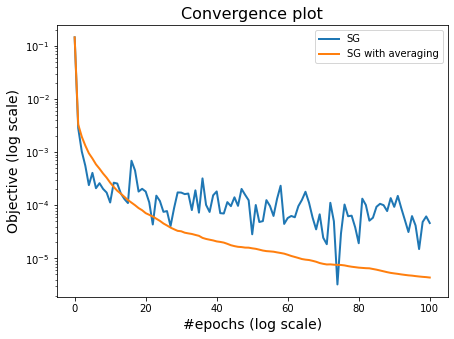

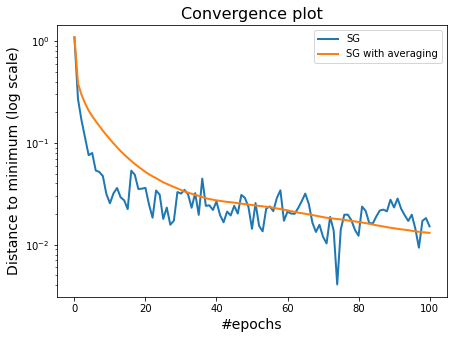

In [45]:
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SG with averaging", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of gradient norm (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_b, label="SG with averaging", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()

### SAGA

In [51]:
def saga(w0,problem,wtarget, n_iter=1000): 
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    # gradient norm history
    normgrads = []
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz and strong convexity constants
    L = problem.lipgrad()
    
    mu = problem.cvxval()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)

    # Initialize iteration counter
    k=0
    
    # Steplength
    alpha = 0.2/(mu*n+L)
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    print("SAGA")
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    
    # Initial gradient calculation
    gavg = np.zeros(d)
    Xw = problem.X.dot(w)
    for i in range(n):
        gavg[:] = gavg + problem.grad_xi(i,Xw[i])
    
    gavg = (1/n)*gavg
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        
        ik = np.random.choice(n,1,replace=True) # Stochastic gradient (1 component)
        xikw = problem.X[ik].dot(w)
        tp = problem.grad_xi(ik,xikw) - problem.grad_xi(ik,Xw[ik])
        sg = tp + gavg
        gavg = gavg + (1/n) * tp
        Xw[ik]=xikw #Update average
        w[:] = w - alpha * sg
        nw = norm(w) #Computing the norm to measure divergence 
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if k % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits)

Stochastic Gradient, batch size= 1 / 5000
  iter   |   fval   |  normit 
       0 | 2.86e-01 | 1.09e+00
    5000 | 1.44e-01 | 3.76e-01
   10000 | 1.42e-01 | 2.74e-01
   15000 | 1.42e-01 | 2.19e-01
   20000 | 1.41e-01 | 1.86e-01
   25000 | 1.41e-01 | 1.60e-01
   30000 | 1.41e-01 | 1.41e-01
   35000 | 1.41e-01 | 1.27e-01
   40000 | 1.41e-01 | 1.14e-01
   45000 | 1.41e-01 | 1.02e-01
   50000 | 1.41e-01 | 9.14e-02
   55000 | 1.41e-01 | 8.33e-02
   60000 | 1.41e-01 | 7.73e-02
   65000 | 1.41e-01 | 7.27e-02
   70000 | 1.41e-01 | 6.82e-02
   75000 | 1.41e-01 | 6.44e-02
   80000 | 1.41e-01 | 6.08e-02
   85000 | 1.41e-01 | 5.75e-02
   90000 | 1.41e-01 | 5.45e-02
   95000 | 1.41e-01 | 5.17e-02
  100000 | 1.41e-01 | 4.93e-02
  105000 | 1.41e-01 | 4.71e-02
  110000 | 1.41e-01 | 4.53e-02
  115000 | 1.41e-01 | 4.34e-02
  120000 | 1.41e-01 | 4.14e-02
  125000 | 1.41e-01 | 3.97e-02
  130000 | 1.41e-01 | 3.81e-02
  135000 | 1.41e-01 | 3.66e-02
  140000 | 1.41e-01 | 3.53e-02
  145000 | 1.41e-01 | 3.40e-

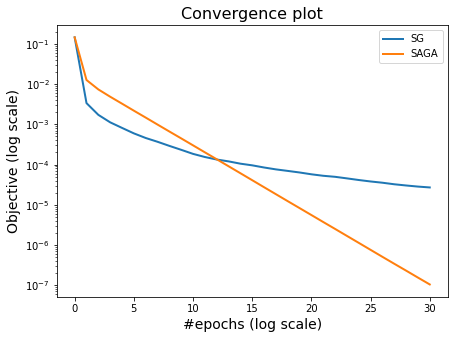

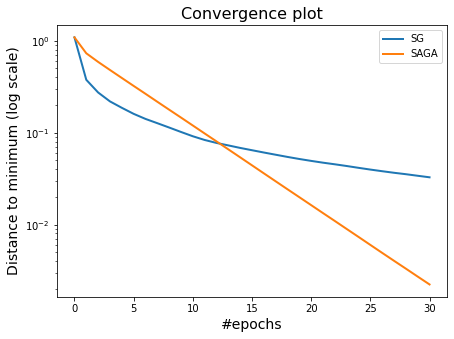

In [53]:
nb_epochs = 30
n = pblinreg.n
w0 = np.zeros(d)
m = 5

# Stochastic gradient (batch size 1) without averaging
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,average=1)
# SAGA
w_b, obj_b, nits_b = saga(w0,pblinreg,w_min_lin,n_iter=nb_epochs*n)

# Plot the results
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SAGA", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of gradient norm (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_b, label="SAGA", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()

## Regularization

### Ridge

We use the formula of the course to compute the minimizer.

In [76]:
# lambda=0
np.linalg.inv(np.dot(X.T,X)+0*np.eye(d)).dot(X.T).dot(y)

array([ 0.10365421, -0.66799852,  0.14608893, -0.49770144,  0.09181733,
        0.32936887, -0.08614103, -0.57869775])

We observe that the variables x5 ('situation', i.e beeing at 18 or 30 months after the end of the studies at the moment of the survey) and x7 ('taux de chomage regional') seem to be the less informative variables for our task. 

In [77]:
# lambda=100
np.linalg.inv(np.dot(X.T,X)+100*np.eye(d)).dot(X.T).dot(y)

array([ 0.10191814, -0.40980607,  0.13529447, -0.39264691,  0.06991984,
        0.32358014, -0.08043899, -0.5142514 ])

We observe that the regularization has not a great impact on the variables, except maybe for the features x2 ('diplome', i.e Master LMD or ENS) and x4 ('discipline'). Let see it graphically. 

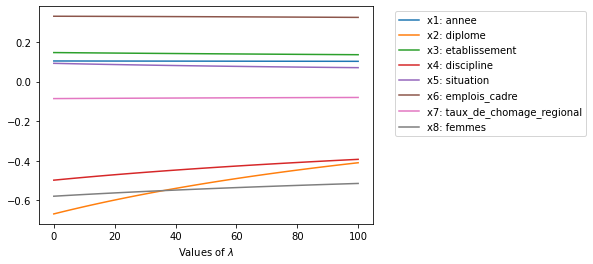

In [79]:
seq=[]
value=np.linspace(0,100,50)

val_x1=[]
val_x2=[]
val_x3=[]
val_x4=[]
val_x5=[]
val_x6=[]
val_x7=[]
val_x8=[]
for lbda in value:
    a= np.linalg.inv(np.dot(X.T,X)+lbda*np.eye(d)).dot(X.T).dot(y)
    val_x1.append(a[0])
    val_x2.append(a[1])
    val_x3.append(a[2])
    val_x4.append(a[3])
    val_x5.append(a[4])
    val_x6.append(a[5])
    val_x7.append(a[6])
    val_x8.append(a[7])

plt.plot(value,val_x1, label='x1: annee')
plt.plot(value,val_x2, label='x2: diplome')
plt.plot(value,val_x3, label='x3: etablissement')
plt.plot(value,val_x4, label='x4: discipline')
plt.plot(value,val_x5, label='x5: situation')
plt.plot(value,val_x6, label='x6: emplois_cadre')
plt.plot(value,val_x7, label='x7: taux_de_chomage_regional')
plt.plot(value,val_x8, label='x8: femmes')
plt.xlabel('Values of $\lambda$')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

We now see what's happening in terms of Mean Square Error.

In [74]:
seq=[]
value=np.linspace(0,100,50)

for lbda in value:
    a=mean_squared_error(w_min_lin, np.linalg.inv(np.dot(X.T,X)+lbda*np.eye(d)).dot(X.T).dot(y))
    seq+=[a]

Text(0, 0.5, 'Mean Squared Error')

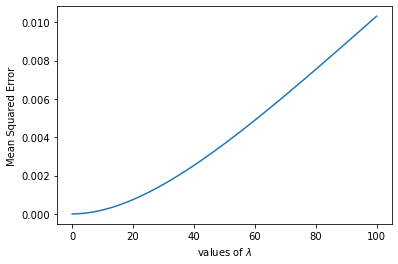

In [75]:
plt.plot(value,seq)
plt.xlabel('values of $\lambda$')
plt.ylabel('Mean Squared Error')

We can deduce from this graphic that the best $\lambda$ is $\lambda=0$, which corresponds to the initial problem without regularization.

### Lasso using iterative soft thresholding

In [91]:
def Soft(x,s): 
    return np.maximum(abs(x)-s, np.zeros(x.shape)) * np.sign(x)

def ISTA(w0,problem,wtarget,lbda,n_iter,tau=1/np.linalg.norm(X)**2):
    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
      
    w = w0.copy()
    nw = norm(w)
    
    # Initialize iteration counter
    k=0

    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    while (k < n_iter and nw < 10**100):
        w=Soft(w-tau*np.dot(X.T,X.dot(w)-y),lbda)
      
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        
        objvals.append(obj)
        normits.append(nmin)              
        k=k+1
    
    w_output = w.copy()
    
    return w_output

In [93]:
ISTA(np.zeros(d),pblinreg,w_min_lin,0.01,100,tau=1/np.linalg.norm(X)**2)

array([ 0.04467003, -0.        ,  0.03956528, -0.19102157,  0.        ,
        0.30251441, -0.04677656, -0.39570074])

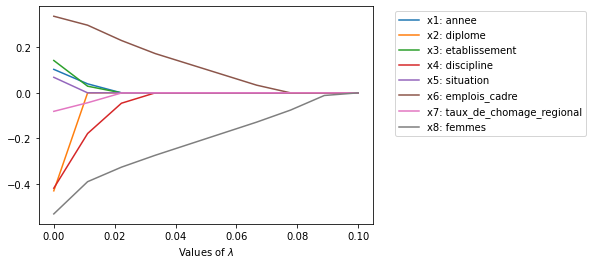

In [94]:
seq=[]
value=np.linspace(0,0.1,10)

val_x1=[]
val_x2=[]
val_x3=[]
val_x4=[]
val_x5=[]
val_x6=[]
val_x7=[]
val_x8=[]
for lbda in value:
    a= ISTA(np.zeros(d),pblinreg,w_min_lin,lbda,100,tau=1/np.linalg.norm(X)**2)
    val_x1.append(a[0])
    val_x2.append(a[1])
    val_x3.append(a[2])
    val_x4.append(a[3])
    val_x5.append(a[4])
    val_x6.append(a[5])
    val_x7.append(a[6])
    val_x8.append(a[7])

plt.plot(value,val_x1, label='x1: annee')
plt.plot(value,val_x2, label='x2: diplome')
plt.plot(value,val_x3, label='x3: etablissement')
plt.plot(value,val_x4, label='x4: discipline')
plt.plot(value,val_x5, label='x5: situation')
plt.plot(value,val_x6, label='x6: emplois_cadre')
plt.plot(value,val_x7, label='x7: taux_de_chomage_regional')
plt.plot(value,val_x8, label='x8: femmes')
plt.xlabel('Values of $\lambda$')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')